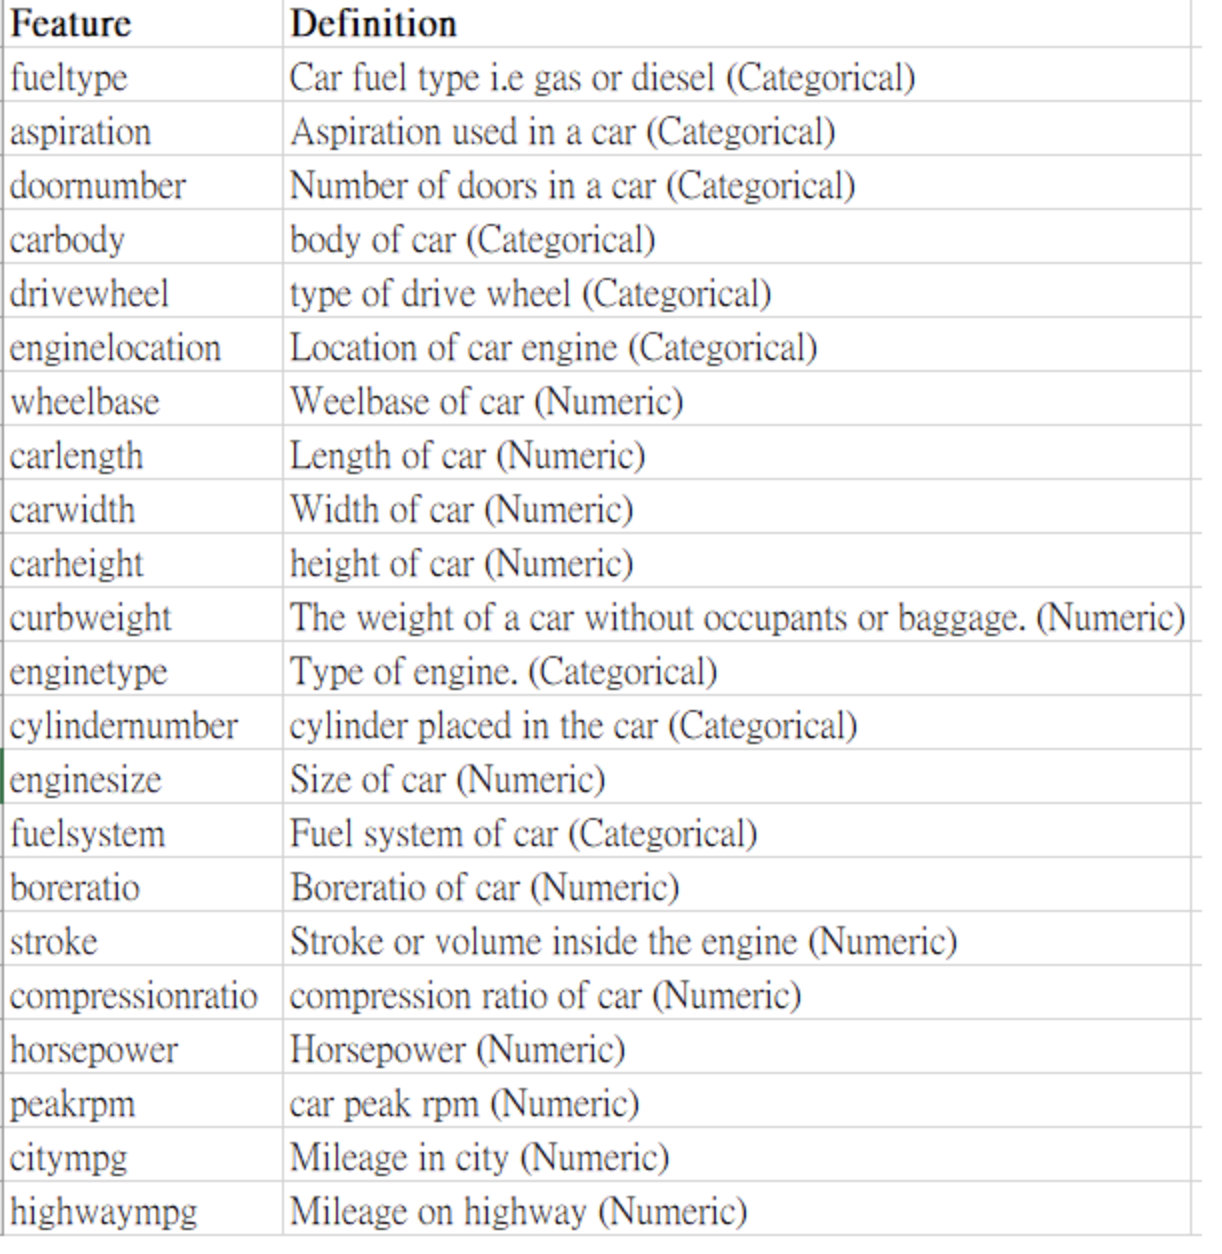

In [1]:
# imports
import joblib, sklearn
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# import shap and initialize javascript for interactive shap plots
import shap
shap.initjs()

In [2]:
# helper function for lin_reg
def get_coefs_linreg(lin_reg, 
                     feature_names = None, 
                     sort = True,
                     ascending = True, 
                     name = 'LinearRegression Coefficients'):
    """Gets coefficients and intercept from the fit linear regression"""
    """Source: Coding Dojo Learn Platform"""
    
    if feature_names is None:
        feature_names = lin_reg.feature_names_in_
        
    ## Saving the coefficients
    coefs = pd.Series(lin_reg.coef_, index = feature_names)
    coefs['intercept'] = lin_reg.intercept_
    if sort == True:
        coefs = coefs.sort_values(ascending = ascending)
    return coefs

In [3]:
#Change the pandas option for float to display the coeffs with pandas in a readable form: 
#separator for thousands, and 2 decimal places.
pd.set_option('display.float_format', lambda x: f"{x:,.2f}")

In [4]:
# bar graph of the coefficients, sorted from largest to smallest.
def annotate_hbars(ax, ha='left', va='center', size=12, xytext=(4,0),
                  textcoords='offset points'):
    """Source: Coding Dojo Learn Platform"""
    
    for bar in ax.patches:

        ## calculate center of bar
        bar_ax = bar.get_y() + bar.get_height() / 2
        ## get the value to annotate
        val = bar.get_width()
        if val < 0:
            val_pos = 0
        else:
            val_pos = val
        # ha and va stand for the horizontal and vertical alignment
        ax.annotate(f"{val:,.2f}", (val_pos,bar_ax), ha=ha, va=va, size=size,
                        xytext=xytext, textcoords=textcoords)

In [5]:
def plot_coeffs(coeffs, top_n=None, figsize=(4,5),
                intercept=False, intercept_name="intercept",
                annotate=False, ha='left', va='center', size=12,
                xytext=(4,0), textcoords='offset points'):
    """ Plots the top_n coefficients from a Series, with optional annotations.
    Source: Coding Dojo Learn Platform"""
    
    # initialize title
    title = 'title'
    
    # Drop intercept if intercept=False and intercept name in coeffs index
    if (intercept == False) & (intercept_name in coeffs.index):
        coeffs = coeffs.drop(intercept_name)
        title = 'Without Intercept'
    
    # plot all coeffs
    if top_n == None:
        
        ## sort all features and set title
        plot_vals = coeffs.sort_values()
        if title == 'title':
            title = "All Coefficients - Ranked by Magnitude"
        else:
            title = "All Coefficients Without Intercept - Ranked by Magnitude"
    
    # plot specified number of coeffs
    else:
        ## rank the coeffs and select the top_n
        coeff_rank = coeffs.abs().rank().sort_values(ascending=False)
        top_n_features = coeff_rank.head(top_n)

        ## sort features and keep top_n and set title
        plot_vals = coeffs.loc[top_n_features.index].sort_values()
        if title == 'title':
            title = f"Top {top_n} Largest Coefficients"
        else:
            title = f"Top {top_n} Largest Coefficients Without Intercept"
        
    ## plot
    ax = plot_vals.plot(kind='barh', figsize=figsize)
    ax.set(xlabel='Coefficient',
            ylabel='Feature Names',
            title=title)
    ax.axvline(0, color='k')
    if annotate == True:
        annotate_hbars(ax, ha=ha, va=va, size=size, xytext=xytext, textcoords=textcoords)
    return ax

In [6]:
#Extract and create a bar graph of the feature importances, sorted from largest to smallest.
def get_importances(model, feature_names=None,name='Feature Importance',
                   sort=False, ascending=True):
    """Gets importances from a tree-based model
    Source: Coding Dojo Learn Platform"""

    ## checking for feature names
    if feature_names == None:
        feature_names = model.feature_names_in_

    ## Saving the feature importances
    importances = pd.Series(model.feature_importances_, index= feature_names,
                           name=name)

    # sort importances
    if sort == True:
        importances = importances.sort_values(ascending=ascending)

    return importances

In [7]:
def plot_importance(importances, top_n=None,  figsize=(8,6)):
    """Plots given importances
    Source: Coding Dojo Learn Platform"""
    
    # sorting with asc=false for correct order of bars
    if top_n==None:
        ## sort all features and set title
        plot_vals = importances.sort_values()
        title = "All Features - Ranked by Importance"
    else:
        ## sort features and keep top_n and set title
        plot_vals = importances.sort_values().tail(top_n)
        title = f"Top {top_n} Most Important Features"
    ## plotting top N importances
    ax = plot_vals.plot(kind='barh', figsize=figsize)
    ax.set(xlabel='Importance',
            ylabel='Feature Names',
            title=title)
    ## return ax in case want to continue to update/modify figure
    return ax

# Part 1

## Prepare Data

In [8]:
#Load the provided joblib file. Display the .keys of the dictionary stored in the joblib file.
loaded = joblib.load("saved_model.joblib")
loaded.keys()

Trying to unpickle estimator SimpleImputer from version 1.2.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
Trying to unpickle estimator Pipeline from version 1.2.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
Trying to unpickle estimator OneHotEncoder from version 1.2.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
Trying to unpickle estimator ColumnTransformer from version 1.2.2 when using version 1.1.3. This might lead to breaking code or invalid results. Us

dict_keys(['preprocessor', 'X_train', 'X_test', 'y_train', 'y_test', 'LinearRegression', 'RandomForestRegressor'])

In [9]:
#Assign each of the keys from the dictionary as a separate variable.
preprocessor = loaded['preprocessor']
X_train = loaded['X_train']
X_test = loaded['X_test']
y_train = loaded['y_train']
y_test = loaded['y_test']
LinearRegression = loaded['LinearRegression']
RandomForestRegressor = loaded['RandomForestRegressor']

In [10]:
#check x_train and x_test
display(X_train.head())
display(X_test.head())

,fueltype,enginelocation,carlength,carwidth,carheight,curbweight,cylindernumber,horsepower,peakrpm,citympg,highwaympg
64,gas,front,177.80,66.50,55.50,2425,4,84,4800,26,32
32,gas,front,150.00,64.00,52.60,1837,4,60,5500,38,42
165,gas,front,168.70,64.00,52.60,2265,4,112,6600,26,29
39,gas,front,175.40,65.20,54.10,2304,4,86,5800,27,33
202,gas,front,188.80,68.90,55.50,3012,6,134,5500,18,23


,fueltype,enginelocation,carlength,carwidth,carheight,curbweight,cylindernumber,horsepower,peakrpm,citympg,highwaympg
101,gas,front,181.70,66.50,55.10,3095,6,152,5200,17,22
111,gas,front,186.70,68.40,56.70,3075,4,95,5000,19,24
142,gas,front,172.00,65.40,52.50,2190,4,82,4400,28,33
34,gas,front,150.00,64.00,52.60,1956,4,76,6000,30,34
27,gas,front,157.30,63.80,50.60,2191,4,102,5500,24,30


In [11]:
#Use the preprocessor to transform the X_train/X_test data into processed dataframes. 
#Replace the column names with the correct feature names extracted from the preprocessor.

feature_names = preprocessor.get_feature_names_out()

X_train_proc = pd.DataFrame(preprocessor.transform(X_train),
                            columns = feature_names,
                            index = X_train.index)
X_test_proc = pd.DataFrame(preprocessor.transform(X_test),
                           columns = feature_names,
                           index = X_test.index)

display(X_train_proc.head())
display(X_test_proc.head())

,carlength,carwidth,carheight,curbweight,cylindernumber,horsepower,peakrpm,citympg,highwaympg,fueltype_gas,enginelocation_rear
64,177.80,66.50,55.50,"2,425.00",4.00,84.00,"4,800.00",26.00,32.00,1.00,0.00
32,150.00,64.00,52.60,"1,837.00",4.00,60.00,"5,500.00",38.00,42.00,1.00,0.00
165,168.70,64.00,52.60,"2,265.00",4.00,112.00,"6,600.00",26.00,29.00,1.00,0.00
39,175.40,65.20,54.10,"2,304.00",4.00,86.00,"5,800.00",27.00,33.00,1.00,0.00
202,188.80,68.90,55.50,"3,012.00",6.00,134.00,"5,500.00",18.00,23.00,1.00,0.00


,carlength,carwidth,carheight,curbweight,cylindernumber,horsepower,peakrpm,citympg,highwaympg,fueltype_gas,enginelocation_rear
101,181.70,66.50,55.10,"3,095.00",6.00,152.00,"5,200.00",17.00,22.00,1.00,0.00
111,186.70,68.40,56.70,"3,075.00",4.00,95.00,"5,000.00",19.00,24.00,1.00,0.00
142,172.00,65.40,52.50,"2,190.00",4.00,82.00,"4,400.00",28.00,33.00,1.00,0.00
34,150.00,64.00,52.60,"1,956.00",4.00,76.00,"6,000.00",30.00,34.00,1.00,0.00
27,157.30,63.80,50.60,"2,191.00",4.00,102.00,"5,500.00",24.00,30.00,1.00,0.00


## Explain the Linear Regression Model:

In [12]:
#Extract the coefficients and save them as a Series with the correct feature names as the index.
coefs = get_coefs_linreg(LinearRegression, feature_names=feature_names, ascending = False)
coefs

enginelocation_rear   13,927.99
cylindernumber         1,394.02
citympg                  154.59
carwidth                 111.22
horsepower                36.44
curbweight                 6.40
intercept                  0.00
peakrpm                   -0.17
carlength                -16.31
carheight               -157.76
highwaympg              -318.09
fueltype_gas          -2,856.99
dtype: float64

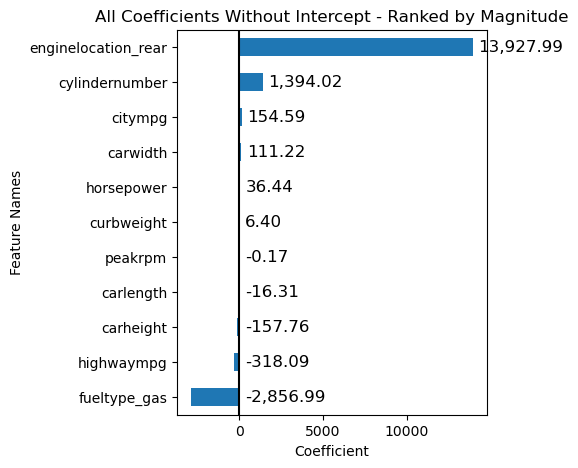

In [13]:
#Create a bar graph of the coefficients, sorted from largest to smallest. 
plot_coeffs(coefs, 
            top_n=None, 
            figsize=(4,5),
            intercept=False,  
            intercept_name="intercept",
            annotate=True, 
            ha='left', 
            va='center', 
            size=12,
            xytext=(4,0), 
            textcoords='offset points');

### Provide a quantitative interpretation (both magnitude and directionality) of the three largest positive coefficients explaining how that feature impacts the target.

- enginelocation_rear (categorical), the model predicts that if the observation belongs to 'enginelocation_rear', then the target sales price will increase by 13,927.99.


- cylindernumber (categorical): the model predicts that if the observation belongs to 'cylindernumber', then the target sales price will increase by 1,394.02.


- citympg (numeric): if everything stayed the same with the car and you were able to increase the citympg, you would increase the overall price by 154.59 with every positive unit increase in citympg.

### Provide a quantitative interpretation (both magnitude and directionality) of the three largest negative coefficients explaining how that feature impacts the target.

- fueltype_gas (categorical): the model predicts that if the observation belongs to 'fueltype_gas', then the target sales price will decrease by 2,856.99.

- highwaympg (numeric): if everything stayed the same with the car and increased the highwaympg, the model predicts to decrease the overall price by 318.09 with every positive unit increase in highwaympg.

- carheight (numeric): if everything stayed the same with the car and increased the carheight, the model predicts to decrease the overall price by 157.76 with every positive unit increase in carheight.

## Explain the Random Forest Model:


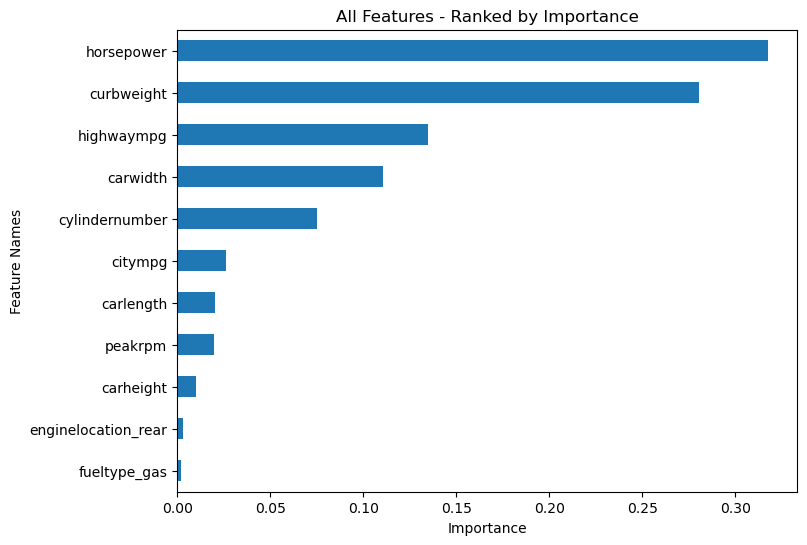

In [15]:
# Extract and create a bar graph of the feature importances, sorted from largest to smallest. 

# get importances
importances = get_importances(RandomForestRegressor, 
                              sort = True,
                              ascending = False,
                              name = 'RandomForest Importances')

# plot importances
plot_importance(importances, top_n=None,  figsize=(8,6));


### What are the top 6 most important features? 
horsepower, curbweight, highwaympg, carwidth, cylindernumber and citympg.

### Of the top 6 most important features, identify which of these features also appeared in the 3 largest or 3 smallest coefficients. 

cylindernumber and citympg are also in the top 3 largest whilst highwaympg is the third lowesr coeffs.

## Apply Shap to Explain the Random Forest Model

In [16]:
#Sample 100 rows of the processed X_train data as X_shap, using random_state=321
X_shap = shap.sample(X_train_proc, nsamples=100, random_state=321)

print(X_shap.info())
X_shap.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100 entries, 99 to 40
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   carlength            100 non-null    float64
 1   carwidth             100 non-null    float64
 2   carheight            100 non-null    float64
 3   curbweight           100 non-null    float64
 4   cylindernumber       100 non-null    float64
 5   horsepower           100 non-null    float64
 6   peakrpm              100 non-null    float64
 7   citympg              100 non-null    float64
 8   highwaympg           100 non-null    float64
 9   fueltype_gas         100 non-null    float64
 10  enginelocation_rear  100 non-null    float64
dtypes: float64(11)
memory usage: 9.4 KB
None


,carlength,carwidth,carheight,curbweight,cylindernumber,horsepower,peakrpm,citympg,highwaympg,fueltype_gas,enginelocation_rear
99,173.40,65.20,54.70,"2,324.00",4.00,97.00,"5,200.00",27.00,34.00,1.00,0.00
138,156.90,63.40,53.70,"2,050.00",4.00,69.00,"4,900.00",31.00,36.00,1.00,0.00
82,173.20,66.30,50.20,"2,833.00",4.00,145.00,"5,000.00",19.00,24.00,1.00,0.00
86,172.40,65.40,51.60,"2,405.00",4.00,88.00,"5,000.00",25.00,32.00,1.00,0.00
79,157.30,63.80,50.80,"2,145.00",4.00,102.00,"5,500.00",24.00,30.00,1.00,0.00


In [19]:
#Save the corresponding y_train values as y_shap
y_shap = y_train.loc[X_shap.index]
y_shap
#Same index as X_shap!

99     8,949.00
138    5,118.00
82    12,629.00
86     8,189.00
79     7,689.00
         ...   
123    8,921.00
85     6,989.00
118    5,572.00
155    8,778.00
40    10,295.00
Name: price, Length: 100, dtype: float64

In [20]:
#Create a shap model explainer for the random forest model
explainer = shap.Explainer(RandomForestRegressor)
explainer
#confirm its a tree model

In [21]:
# Calculate the shap values for the sampled data
shap_values = explainer(X_shap, y_shap)
pd.DataFrame(shap_values.values, columns = X_shap.columns)

,carlength,carwidth,carheight,curbweight,cylindernumber,horsepower,peakrpm,citympg,highwaympg,fueltype_gas,enginelocation_rear
0,-106.53,-571.12,55.24,-785.19,-322.28,-980.49,-85.74,-92.41,"-1,051.56",-10.67,-6.27
1,-307.11,-945.82,27.79,"-2,617.67",-432.55,"-1,499.20",-91.69,-31.78,"-1,357.23",-2.98,-6.19
2,-269.30,-721.19,-101.59,780.66,-274.55,-459.39,-481.93,-58.71,"1,391.51",-10.45,-24.70
3,-217.68,-669.39,-86.48,-699.76,-364.98,"-1,289.09",-234.22,-153.80,"-1,151.45",-17.19,-6.21
4,-67.57,-585.05,5.24,"-2,085.82",-366.29,-837.33,59.26,-104.77,"-1,204.42",-7.16,-6.21
...,...,...,...,...,...,...,...,...,...,...,...
95,19.41,-620.55,-82.44,-241.45,-362.41,"-1,235.96",-181.73,-180.07,"-1,111.73",-22.41,-6.18
96,-221.47,-680.80,-117.34,"-1,099.33",-370.35,"-1,329.83",-282.97,-158.38,"-1,094.50",-11.64,-6.21
97,-178.78,-589.81,16.85,"-3,133.04",-395.87,"-1,783.58",41.72,-135.62,"-1,364.44",-8.20,-6.18
98,-46.81,-970.78,-335.88,"2,483.14",-382.32,"-1,681.64",-173.47,-92.77,"-1,130.05",-12.26,-16.27


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


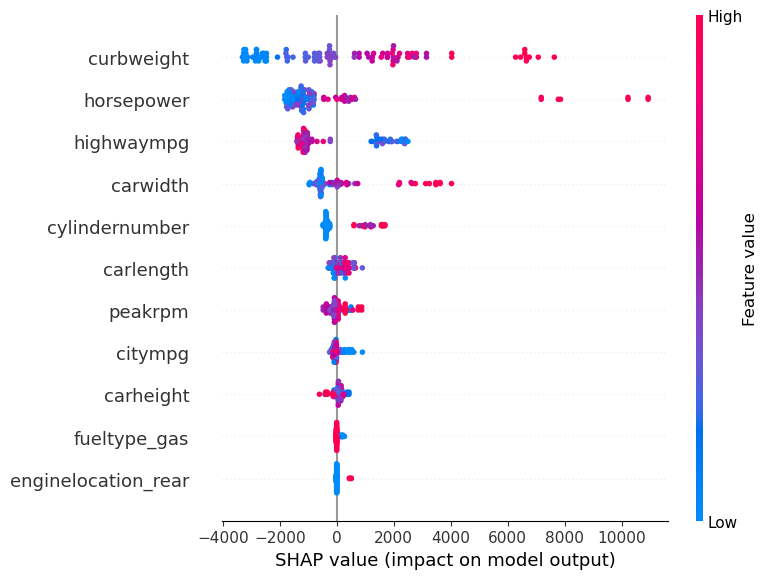

In [24]:
#Create a summary plot (plot_type =’dot’) of the most important features, according to shap.
shap.summary_plot(shap_values, X_shap)

Interpret the top 6 most important features. According to shap, what effect does each feature have on the model’s prediction?

# Part 2

# Part 3